# Assignment2, CMPT826

* Seyedeh Mina Mousavifar
* 11279515
* sem311

##  STEP 1: Preparation

### Data Collection

In [2]:
import pandas as pd
import sqlalchemy as db

engine = db.create_engine('mysql:?@crepe.usask.ca:3306/SHED10')

connection = engine.connect()
metadata = db.MetaData()

# Equivalent to 'SELECT * FROM battery
battery = db.Table('battery', metadata, autoload=True, autoload_with=engine)
query = db.select([battery])

# getting data by executing the query above
BatteryResultProxy = connection.execute(query)
BatteryResultSet = BatteryResultProxy.fetchall()

# converting data to data frame
battery_data = pd.DataFrame(BatteryResultSet)
battery_data.columns = BatteryResultSet[0].keys()

# removing index column from data - 0 for rows and 1 for column
battery_data = battery_data.drop('index', 1)

# Equivalent to 'SELECT * FROM gps
gps = db.Table('gps', metadata, autoload=True, autoload_with=engine)
query = db.select([gps])

# getting data by executing the query above
GPSResultProxy = connection.execute(query)
GPSResultSet = GPSResultProxy.fetchall()

# converting data to data frame
gps_data = pd.DataFrame(GPSResultSet)
gps_data.columns = GPSResultSet[0].keys()

# removing index column from data - 0 for rows and 1 for column
gps_data = gps_data.drop('index', 1)

print('fetching data completed')

fetching data completed


### Filtering Data

In [3]:
# counting number of battery information per user
battery_info = battery_data.groupby(['user_id']).size().reset_index(name='record_count')

# calculating filtering cutoff
cutoff_percentage = 0.5
max_battery_info = (60 / 5) * 24 * 30
battery_cutoff = cutoff_percentage * max_battery_info

# filtering users with less than 50%
battery_info_50 = battery_info.loc[battery_info['record_count'] > battery_cutoff]
users_filter_50, _ = battery_info_50.shape

# preserving only users with more than 50% battery record
user_battery = pd.merge(left=battery_data, right=battery_info_50, 
                           left_on='user_id', right_on='user_id')

# filtering accuracy more than 100
gps_data = gps_data.loc[gps_data['accu'] < 100]

# outside latitude range
gps_data = gps_data.loc[gps_data['lat'] > 52.058366]
gps_data = gps_data.loc[gps_data['lat'] < 52.214609]

# outside longitude range
gps_data = gps_data[gps_data['lon'] > -106.7649138128]
gps_data = gps_data.loc[gps_data['lon'] < -106.52225319]

# creating dataframe for filtering Saskatoon data for preferred users
good_50_user_id = user_battery.user_id.unique()
gps_data = gps_data[gps_data.user_id.isin(good_50_user_id)]

### Stratify and Aggregate

In [4]:
import datetime
import math
from pyproj import Proj
import numpy as np

# removing unnecessary columns
gps_data = gps_data.drop(['accu', 'alt', 
                          'bearing', 'speed', 
                          'record_time_minute', 
                          'timestamp', 'pokemon'], 1)

# calculating mean of latitude and longitude for every duty cycle
gps_data = gps_data.astype({'lat': 'float64', 'lon': 'float64'})

# sorting based on time 
gps_data = gps_data.sort_values(['user_id', 'record_time'])

# removing December test data
gps_data['Date'] = pd.to_datetime(gps_data['record_time']).dt.date
testdate = datetime.datetime.strptime('2016-12-09', "%Y-%m-%d").date()
gps_data = gps_data[(gps_data['Date'] > testdate)].dropna().reset_index()
gps_data = gps_data.drop(['Date', 'index'],1)


# extract duty cycles and calculate mean of latitude and longitude
gps_data = gps_data.groupby('user_id').resample('5T', on='record_time').mean()
gps_data = gps_data.drop(['user_id'],1).reset_index()

# converting to UTM
myproj = Proj('epsg:32613', proj='utm', zone=13, 
              ellps='WGS84', preserve_units=True)

gps_data['x'], gps_data['y'] = myproj(gps_data['lon'].values, 
                                      gps_data['lat'].values)
# binning
GRID_SIZE = 100

# find grid start point
start_x, start_y = gps_data.x.min(), gps_data.y.min()

# labeling grids
gps_data['x_grid'] = np.ceil((gps_data['x'] - start_x)/GRID_SIZE)
gps_data['y_grid'] = np.ceil((gps_data['y'] - start_y)/GRID_SIZE)

# sort data
gps_data = gps_data.sort_values(['user_id', 'record_time']).dropna()

# creating grid cell labels (x,y)
gps_data = gps_data.astype({'x_grid': 'int32', 
                            'y_grid': 'int32'}).astype({'x_grid': 'str', 
                                                        'y_grid': 'str'})
gps_data['grid_label'] = gps_data['x_grid'] + ',' + gps_data['y_grid']
gps_data = gps_data.astype({'x_grid': 'int32', 'y_grid': 'int32'})

##  STEP 2: Trip Definition

### Operationalizing trips

For finding trips, first, I compare two consecutive rows for a user and discover whether it had changed its cell. Then, I gave id for these change cells to make them traceable as different trajectories. So, the stayed time in each cell can be calculated by grouping based on a specific user, grid and trajectory id. Afterwards, trips can be operationalized as staying in a cell more than a certain threshold will end the trip and leaving the cell start a trip. So we end a trip as soon as we know that it a user will stay in this cell more than certain threshold.

In [287]:
# change cell condition
gps_data['change_cell'] = np.where(gps_data['grid_label'] != gps_data['grid_label'].shift(1), 1, 0)
gps_data['change_cell'] = np.where(gps_data['user_id'] == gps_data['user_id'].shift(1), 
                                   gps_data['change_cell'], 0)

# change in a cell can be used as change id for showing user trajectory
gps_data['change_id'] = gps_data.groupby('user_id')['change_cell'].cumsum()

In [288]:
def trip_finder(data_in, n_in):
    '''
    This functions find trips from GPS data
    :param data_in: gps records
    :param n-in: N in which ends trips more than this threshold
    :return trip: trips dataset consist of trip_id column
    '''
    # calculating staying time in one cell during their change
    trip = data_in.groupby(['user_id', 
                'grid_label', 
                'change_id']).size().reset_index(name = 'stay_count')

    trip['is_dwell'] = np.where(trip['stay_count'] > n_in, 1, 0)

    # sorting data based on time
    trip = trip.sort_values(['user_id', 'change_id'])
    trip = trip.reset_index().drop(['index'], 1)

    # trips are calculated as time between dwells
    trip['trip_id'] = trip.groupby('user_id')['is_dwell'].cumsum()
    
    return trip

#### Trip length
This is the number of different grids seen until dwelling. So I grouped based on user and trip id in trip data and calculated the number of rows available in each group.

In [289]:
def trip_length(data_in):
    '''
    This functions find trips length from trips data
    :param data_in: trips records
    :return info: trips info dataset consist of 
    length column for each trip
    '''
    info = data_in.groupby(['user_id',
        'trip_id']).size().reset_index(name = 'length')
    
    return info

#### Number of Trips
This is the number of trips founded for each user, which can be calculated by counting number of rows for each user in trip data or trip info data.

In [290]:
def trip_number(data_in):
    '''
    This functions find number of total number of trips
    for each user
    :param data_in: trips info records
    :return trip_num: trips info dataset consist of 
    count column for each user
    '''
    trip_num = data_in.groupby('user_id').size().reset_index(name = 'count')
    
    return trip_num

#### Time of each trip

The trip time is the summation of staying in each cell involved in the trip. However, if the user gets into a grid in which it will stay there more than $N$, I will immediately end the trip and count its staying time as one.

In [291]:
def trip_time(data_in, n_in, info_in):
    '''
    This functions find trips time from trips data
    :param data_in: trip data
    :param n-in: N in which ends trips more than this threshold
    :param info_in: the previous trip info consisting trip length
    :return info: full trips info including trip length and trip time
    for each trip and each user
    '''
    # change dwellings that are more than threshold to 1 to 
    # calculate them as just 1 duty cycle just as entering the cell
    tmp_trip = data_in.copy(deep=True)
    tmp_trip.loc[tmp_trip.stay_count > n_in, 'stay_count'] = 1
    
    trip_time = tmp_trip.groupby(['user_id', 
                'trip_id']).agg(time = ('stay_count', 'sum'))
    trip_time = trip_time.reset_index()

    # add it trip length to have full trip info
    info = pd.merge(info_in, trip_time, how='inner', on=['user_id', 'trip_id'])
    
    return info

#### $N = 1$
This means that staying in a cell more than 1 duty cycle ends the trip and leaving the cell start a trip.

In [292]:
TRIP_N = 1

gps_trip_1 = trip_finder(gps_data, TRIP_N)

gps_trip_1.head(10)

,user_id,grid_label,change_id,stay_count,is_dwell,trip_id
0,514,"59,69",0,1,0,0
1,514,"59,70",1,1,0,0
2,514,"59,69",2,3,1,1
3,514,"59,70",3,1,0,1
4,514,"59,69",4,5,1,2
5,514,"59,70",5,4,1,3
6,514,"59,69",6,1,0,3
7,514,"59,70",7,1,0,3
8,514,"59,69",8,2,1,4
9,514,"59,70",9,1,0,4


#### Trip length
This is the number of different grids seen until dwelling.

In [294]:
trip_info_1 = trip_length(gps_trip_1)

trip_info_1.head(10)

,user_id,trip_id,length
0,514,0,2
1,514,1,2
2,514,2,1
3,514,3,3
4,514,4,4
5,514,5,2
6,514,6,2
7,514,7,2
8,514,8,1
9,514,9,3


#### Number of Trips

In [295]:
trip_num_1 = trip_number(trip_info_1)

trip_num_1.head(10)

,user_id,count
0,514,814
1,534,197
2,551,717
3,555,409
4,559,307
5,767,130
6,793,228
7,933,315
8,942,196
9,943,208


#### Time of each trip

Time of each trip is the sum of staying in each cell involved in the trip is the trip time.

In [296]:
trip_info_1 = trip_time(gps_trip_1, TRIP_N, trip_info_1)

trip_info_1.head(10)

,user_id,trip_id,length,time
0,514,0,2,2
1,514,1,2,2
2,514,2,1,1
3,514,3,3,3
4,514,4,4,4
5,514,5,2,2
6,514,6,2,2
7,514,7,2,2
8,514,8,1,1
9,514,9,3,3


#### $N = 3$
This means that staying in a cell more than 3 duty cycle ends the trip and leaving the cell less than or equal to 3 duty cycle start a trip.

In [297]:
TRIP_N = 3

gps_trip_3 = trip_finder(gps_data, TRIP_N)

#### Trip length

In [298]:
trip_info_3 = trip_length(gps_trip_3)

trip_info_3.head(10)

,user_id,trip_id,length
0,514,0,4
1,514,1,1
2,514,2,11
3,514,3,2
4,514,4,12
5,514,5,2
6,514,6,2
7,514,7,2
8,514,8,5
9,514,9,9


#### Number of Trips

In [299]:
trip_num_3 = trip_number(trip_info_3)

trip_num_3.head(10)

,user_id,count
0,514,506
1,534,140
2,551,467
3,555,249
4,559,203
5,767,87
6,793,139
7,933,198
8,942,120
9,943,123


#### Time of each trip

In [300]:
trip_info_3 = trip_time(gps_trip_3, TRIP_N, trip_info_3)

trip_info_3.head(10)

,user_id,trip_id,length,time
0,514,0,4,6
1,514,1,1,1
2,514,2,11,15
3,514,3,2,2
4,514,4,12,17
5,514,5,2,2
6,514,6,2,3
7,514,7,2,2
8,514,8,5,6
9,514,9,9,13


#### $N = 5$
This means that staying in a cell more than 5 duty cycle ends the trip and leaving the cell less than or equal to 5 duty cycle start a trip.

In [301]:
TRIP_N = 5

gps_trip_5 = trip_finder(gps_data, TRIP_N)

#### Trip length

In [302]:
trip_info_5 = trip_length(gps_trip_5)

trip_info_5.head(10)

,user_id,trip_id,length
0,514,0,18
1,514,1,12
2,514,2,4
3,514,3,2
4,514,4,5
5,514,5,9
6,514,6,6
7,514,7,6
8,514,8,2
9,514,9,2


#### Number of Trips

In [303]:
trip_num_5 = trip_number(trip_info_5)

trip_num_5.head(10)

,user_id,count
0,514,333
1,534,123
2,551,353
3,555,180
4,559,165
5,767,83
6,793,113
7,933,151
8,942,90
9,943,92


#### Time of each trip

In [304]:
trip_info_5 = trip_time(gps_trip_5, TRIP_N, trip_info_5)

trip_info_5.head(10)

,user_id,trip_id,length,time
0,514,0,18,35
1,514,1,12,17
2,514,2,4,8
3,514,3,2,2
4,514,4,5,6
5,514,5,9,13
6,514,6,6,9
7,514,7,6,16
8,514,8,2,2
9,514,9,2,5


##  STEP 3: Presentation

### Distributions for trip number (over participants)

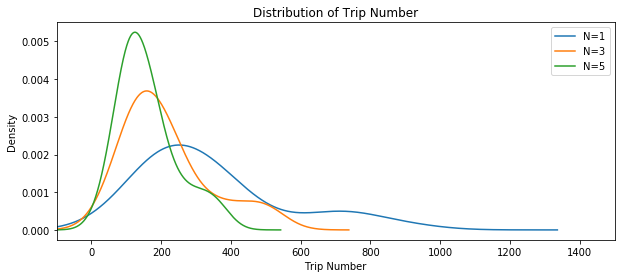

In [310]:
import matplotlib.pyplot as plt

# merging all trip counts for users for different N
trip_num = pd.merge(trip_num_1, trip_num_3, how='inner', on=['user_id'])
trip_num = pd.merge(trip_num, trip_num_5, how='inner', on=['user_id'])
trip_num = trip_num.drop(['user_id'], 1)
trip_num = trip_num.rename(columns={'count_x': 'N=1', 
                                    'count_y': 'N=3',
                                    'count': 'N=5'})

plot = trip_num.plot.kde(figsize=(10, 4),
                         bw_method=0.5)

plot = plot.set(xlabel='Trip Number', 
                xlim= (-100,1500),
                title = 'Distribution of Trip Number')

### Distributions for trip length (over participant-trips)

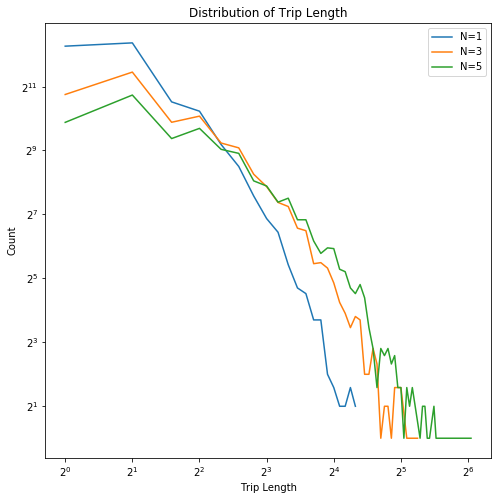

In [307]:
# set size of figure
plt.figure(figsize=(8, 8))
# set title
plt.title('Distribution of Trip Length')
plt.xlabel('Trip Length')
plt.ylabel('Count')

# calculate count of trip length
length_1 = trip_info_1.groupby(['length']).size().reset_index(name='count')
length_3 = trip_info_3.groupby(['length']).size().reset_index(name='count')
length_5 = trip_info_5.groupby(['length']).size().reset_index(name='count')

plt.plot(length_1['length'], length_1['count'], label='N=1')
plt.plot(length_3['length'], length_3['count'], label='N=3')
plt.plot(length_5['length'], length_5['count'], label='N=5')

plt.xscale('log', basex=2)
plt.yscale('log', basey=2)

plt.legend()

plt.show()

### Distributions for trip duration (over participant-trips)

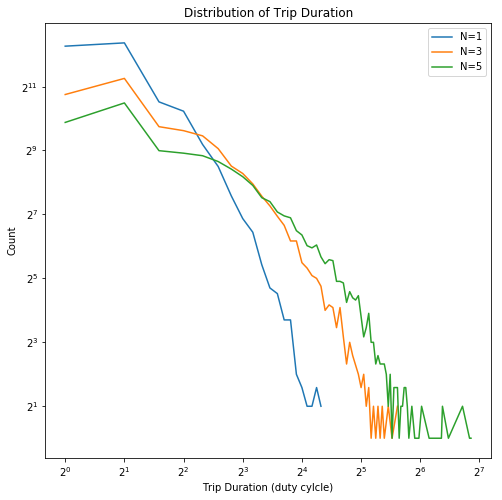

In [308]:
# set size of figure
plt.figure(figsize=(8, 8))
# set title
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (duty cylcle)')
plt.ylabel('Count')

# calculate count of trip length
time_1 = trip_info_1.groupby(['time']).size().reset_index(name='count')
time_3 = trip_info_3.groupby(['time']).size().reset_index(name='count')
time_5 = trip_info_5.groupby(['time']).size().reset_index(name='count')

plt.plot(time_1['time'], time_1['count'], label='N=1')
plt.plot(time_3['time'], time_3['count'], label='N=3')
plt.plot(time_5['time'], time_5['count'], label='N=5')

plt.xscale('log', basex=2)
plt.yscale('log', basey=2)

plt.legend()

plt.show()

### Plot a heat map

#### Over all participants which includes only trips

In [322]:
import os
import folium
from folium.plugins import HeatMap

def plot_heatmap(data_in, grid_in, name_in):
    '''
    This functions plot heatmaps from trips data by
    converting converting grid labels to x,y and 
    then convert it from utm to lat and lon.
    :param data_in: trip data
    :param grid_in: grid size
    :param name_in: saved heatmap name
    :return hmap: save heatmap
    '''
    # converting grid label to x,y
    data_in[['x_grid','y_grid']] = data_in.grid_label.str.split(",",expand=True)

    # covert to float
    data_in = data_in.astype({'x_grid': 'float64',
                    'y_grid': 'float64',
                    'grid_count': 'float64'})

    # calculate center of grid to convert to latitude and longitude for heatmap plotting
    data_in['x_center'] = data_in['x_grid']*grid_in - (0.5*grid_in) + start_x
    data_in['y_center'] = data_in['y_grid']*grid_in - (0.5*grid_in) + start_y

    # convert to latitude and longitude
    myproj = Proj('epsg:32613', proj='utm', zone=13, ellps='WGS84', preserve_units=True)

    data_in['lon_center'], data_in['lat_center'] = myproj(data_in['x_center'].values, 
                                                data_in['y_center'].values, 
                                                inverse=True)

    # creating map
    hmap_data = folium.Map(location=[52.058367, -106.7649138128])

    # plotting map
    hm_wide = HeatMap(list(zip(data_in.lat_center.values, 
                           data_in.lon_center.values,
                           data_in.grid_count.values)), 
                  radius=13)
    
    # fit map zoom
    hmap_data.fit_bounds([data_in[['lat_center', 'lon_center']].min().values.tolist(),
                      data_in[['lat_center', 'lon_center']].max().values.tolist()]) 

    hmap_data.add_child(hm_wide)
    
    # exporting map as html file
    string = str(name_in) + '.html'
    hmap_data.save(os.path.join('map', string))

    return hmap_data

In [323]:
def trip_counter(data_in, n_in):
    '''
    This functions extract trips and 
    count occurance of trips in each grid.
    :param data_in: trip data
    :return trip: the aggregated trip count per grid
    '''
    # change dwellings that are more than threshold to 1 to 
    # calculate them as just 1 duty cycle just as entering the cell
    trip = data_in.copy(deep=True)
    trip.loc[trip.stay_count > n_in, 'stay_count'] = 1

    # merging data for staying in cells
    #  because here the occurance is important not trajectory
    trip = trip.groupby(['grid_label']).agg(grid_count = ('stay_count',
                                                          'sum'))
    trip = trip.reset_index()
    
    return trip

#### $N=1$

In [331]:
TRIP_N = 1

trip_map = trip_counter(gps_trip_1, TRIP_N)

plot_heatmap(trip_map, GRID_SIZE, 'trip_1')

$N=3$

In [332]:
TRIP_N = 3

trip_map = trip_counter(gps_trip_3, TRIP_N)

plot_heatmap(trip_map, GRID_SIZE, 'trip_3')

$N=5$

In [333]:
TRIP_N = 5

trip_map = trip_counter(gps_trip_5, TRIP_N)

plot_heatmap(trip_map, GRID_SIZE, 'trip_5')

#### Over all participants which includes only non-trips for each N

In [327]:
def nontrip_counter(data_in, n_in):
    '''
    This functions extract dwells and 
    count occurance of dwells in each grid.
    :param data_in: trip data
    :return non_trip: the aggregated stay count per grid
    '''
    # change dwellings that are more than threshold to 1 to 
    # calculate them as just 1 duty cycle just as entering the cell
    non_trip = data_in.loc[data_in['stay_count'] >= n_in]

    # merging data for staying in cells
    #  because here the occurance is important not trajectory
    non_trip = non_trip.groupby(['grid_label']).agg(grid_count = ('stay_count', 'sum'))
    non_trip = non_trip.reset_index()
    
    return non_trip

$N=1$

In [328]:
TRIP_N = 1

nontrip_map = nontrip_counter(gps_trip_1, TRIP_N)

plot_heatmap(nontrip_map, GRID_SIZE, 'nontrip_1')

$N=3$

In [329]:
TRIP_N = 3

nontrip_map = nontrip_counter(gps_trip_3, TRIP_N)

plot_heatmap(nontrip_map, GRID_SIZE, 'nontrip_3')

$N=5$

In [330]:
TRIP_N = 5

nontrip_map = nontrip_counter(gps_trip_5, TRIP_N)

plot_heatmap(nontrip_map, GRID_SIZE, 'nontrip_5')